# Stats analysis of chapter 2

Looking at Feather Growth Bars (FGB) as a function of distance to range edge and forest cover

### Load packages

In [3]:
library(brms) # for Bayesian analysis
library(tidyverse) # for tidy code
library(egg) # for nice professional figures
library(lme4) # for frequentist analysis
library(lmerTest) # for p-values
library(GGally) # for ggpairs
library(tidybayes) # for plotting bayes models

library(magrittr)
library(modelr)
library(ggdist)
library(cowplot)
library(rstan)
library(ggrepel)
library(RColorBrewer)
library(posterior)

Loading required package: Rcpp

Loading 'brms' package (version 2.16.1). Useful instructions
can be found by typing help('brms'). A more detailed introduction
to the package is available through vignette('brms_overview').


Attaching package: ‘brms’


The following object is masked from ‘package:stats’:

    ar


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.2     ✔ dplyr   1.0.6
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: gridExtra


Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine


Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack



Attaching p

In [4]:
getwd()

[1] "/Users/tom/OneDrive - Imperial College London/1.PHD/2.R-dir/2.chapter/2.notebook"

### Load forest cover data

In [5]:
FC <- read_csv("../2.data_cleaned/FC_calculated.csv", 
               col_types = cols(
                  species = col_character(),  # load column as character
                  bird_id = col_factor()
                    )) %>% dplyr::select(-"X0")

In [6]:
head(FC)

species,decade,biome,bird_id,lon_dd,lat_dd,dist_km,geometry,file_name,FC_buffer,FC_percentage.value
<chr>,<dbl>,<chr>,<fct>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>
Vireo_olivaceus,1995,AMAZONIA,105244,-63.02141,-7.516036,1059.84,"c(-63.0214128, -7.5160361)",COLECAO_5_AMAZONIA-1995.tif,100,NA
Vireo_olivaceus,1995,AMAZONIA,105244,-63.02141,-7.516036,1059.84,"c(-63.0214128, -7.5160361)",COLECAO_5_AMAZONIA-1995.tif,200,1.428571
Vireo_olivaceus,1995,AMAZONIA,105244,-63.02141,-7.516036,1059.84,"c(-63.0214128, -7.5160361)",COLECAO_5_AMAZONIA-1995.tif,300,5.128205
Vireo_olivaceus,1995,AMAZONIA,105244,-63.02141,-7.516036,1059.84,"c(-63.0214128, -7.5160361)",COLECAO_5_AMAZONIA-1995.tif,400,7.308378
Vireo_olivaceus,1995,AMAZONIA,105244,-63.02141,-7.516036,1059.84,"c(-63.0214128, -7.5160361)",COLECAO_5_AMAZONIA-1995.tif,500,7.798165
Vireo_olivaceus,1995,AMAZONIA,105244,-63.02141,-7.516036,1059.84,"c(-63.0214128, -7.5160361)",COLECAO_5_AMAZONIA-1995.tif,600,8.047809


#### Make sure that all NAs in column percentage of FC are zeros
The function used to calculate FC in the previous script would give NAs if the landscape metric 'proportion of class' (3 for FC in MAPBIOMAS) was innexistent. That means that forest cover was innexistent, therefore NA = 0%. That happened often for smaller buffer radius like 100 m.  

In [7]:
FC$FC_percentage.value[is.na(FC$FC_percentage.value)] <- 0

### Load distance to range edge data

In [8]:
dist <- read_csv("../2.data_cleaned/NHM-MZUSP_dist2edge_data.csv",
    col_types = cols(
      species = col_character(),
      subspecies = col_character(),
      date_collected = col_double(),
      bird_id = col_factor(),
      lon_dd = col_double(),
      lat_dd = col_double(),
      location = col_character(),
      sex = col_character(),
      feather_tail = col_character(),
      source = col_character(),
      distance = col_double(),
      inrange = col_logical(),
      in_costal_margin = col_logical(),
      distance_sgn = col_double(),
      dist_km = col_double()))%>%
  dplyr::select(-c("in_costal_margin","feather_tail", "distance", "sex")) %>% # remove unnecessary columns
  filter(inrange == TRUE, source == "MZUSP") # keep only specimens inside the range
    

In [9]:
 head(dist)

dist %>% 
pull(dist_km) %>%
min()

species,subspecies,date_collected,bird_id,lon_dd,lat_dd,location,source,inrange,distance_sgn,dist_km
<chr>,<chr>,<dbl>,<fct>,<dbl>,<dbl>,<chr>,<chr>,<lgl>,<dbl>,<dbl>
Automolus_leucophthalmus,Automolus_leucophthalmus_leucophthalmus,2016,104089,-48.85236,-27.81322,"Aguas Mornas, SC, Brasil",MZUSP,TRUE,573795.5,573.7955
Automolus_leucophthalmus,Automolus_leucophthalmus_sulphuracens,2010,91247,-49.80011,-28.70533,"Morro Grande, Nova Roma, Pousada Rancho Fundo, SC, Brasil",MZUSP,TRUE,438855.6,438.8556
Automolus_leucophthalmus,Automolus_leucophthalmus_sulphuracens,2010,91248,-48.23111,-25.20336,"Guaraqueçaba, Utinga, PR, Brasil",MZUSP,TRUE,737778.6,737.7786
Automolus_leucophthalmus,Automolus_leucophthalmus_sulphuracens,2002,75697,-49.80359,-23.87488,"Wenceslau Bras, PR, Brasil",MZUSP,TRUE,521216.6,521.2166
Automolus_leucophthalmus,Automolus_leucophthalmus_sulphuracens,2002,75631,-50.00111,-23.93333,"Fazenda Chapadão, Pinhalão, PR, Brasil",MZUSP,TRUE,512959.4,512.9594
Automolus_leucophthalmus,Automolus_leucophthalmus_sulphuracens,2012,93205,-45.88944,-23.65417,"Estacao Biologica de Boraceia, Salesópolis, SP, Brasil",MZUSP,TRUE,689646.5,689.6465


[1] 4.905833

### Load FGB data

In [10]:
# load feather growth bar data
FGB <-read_csv("../2.data_cleaned/fgb_width/MZUSP_fgb_mean_per_individual.csv", 
               col_types = cols(
                  species = col_character(),
                  bird_id = col_factor(),
                  mean_fgb = col_double(),
                  n_bars = col_double()
                ))

In [11]:
print(paste(n_distinct(FGB$bird_id), "specimens out of", n_distinct(FGB$species), "species"))

head(FGB)

FGB %>% 
pull(mean_fgb) %>%
range()

[1] "342 specimens out of 20 species"


species,bird_id,mean_fgb,n_bars
<chr>,<fct>,<dbl>,<dbl>
A_leucophthalmus,66941,176.5231,6
A_leucophthalmus,75569,199.7688,6
A_leucophthalmus,75596,214.8527,5
A_leucophthalmus,75631,127.2994,4
A_leucophthalmus,75697,142.6025,2
A_leucophthalmus,79904,127.4633,10


[1]  68.58591 233.25637

### Manipulate FGB data for analysis

Join FGB dataset to the distances dataset

In [12]:
FGB_data <- dist %>% dplyr::left_join(FGB, by="bird_id")%>% # join dataset by bird_id
                dplyr::select(-"species.y")%>% # remove column created from joining FGB dataset to dist dataset
                filter(!is.na(mean_fgb))%>% # remove rows with NAs in fgb
                rename(species = species.x) # rename column created from joining FGB dataset to dist dataset

head(FGB_data)

print(paste(n_distinct(FGB_data$bird_id), "specimens out of", n_distinct(FGB_data$species), "species"))

species,subspecies,date_collected,bird_id,lon_dd,lat_dd,location,source,inrange,distance_sgn,dist_km,mean_fgb,n_bars
<chr>,<chr>,<dbl>,<fct>,<dbl>,<dbl>,<chr>,<chr>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>
Automolus_leucophthalmus,Automolus_leucophthalmus_leucophthalmus,2016,104089,-48.85236,-27.81322,"Aguas Mornas, SC, Brasil",MZUSP,TRUE,573795.5,573.7955,161.4478,6
Automolus_leucophthalmus,Automolus_leucophthalmus_sulphuracens,2010,91247,-49.80011,-28.70533,"Morro Grande, Nova Roma, Pousada Rancho Fundo, SC, Brasil",MZUSP,TRUE,438855.6,438.8556,147.2222,7
Automolus_leucophthalmus,Automolus_leucophthalmus_sulphuracens,2010,91248,-48.23111,-25.20336,"Guaraqueçaba, Utinga, PR, Brasil",MZUSP,TRUE,737778.6,737.7786,167.6431,6
Automolus_leucophthalmus,Automolus_leucophthalmus_sulphuracens,2002,75697,-49.80359,-23.87488,"Wenceslau Bras, PR, Brasil",MZUSP,TRUE,521216.6,521.2166,142.6025,2
Automolus_leucophthalmus,Automolus_leucophthalmus_sulphuracens,2002,75631,-50.00111,-23.93333,"Fazenda Chapadão, Pinhalão, PR, Brasil",MZUSP,TRUE,512959.4,512.9594,127.2994,4
Automolus_leucophthalmus,Automolus_leucophthalmus_sulphuracens,2012,93205,-45.88944,-23.65417,"Estacao Biologica de Boraceia, Salesópolis, SP, Brasil",MZUSP,TRUE,689646.5,689.6465,113.8112,8


[1] "324 specimens out of 20 species"


In [13]:
anti_join(FGB, dist, by="bird_id") # these individuals are outside the bird ranges, that's why they do not appear in the dist dataset

species,bird_id,mean_fgb,n_bars
<chr>,<fct>,<dbl>,<dbl>
C_speciosum,88293,190.1351,3
C_speciosum,90264,150.4016,8
C_speciosum,90265,148.6608,5
L_amaurocephalus,100606,136.8206,6
L_rufaxilla,65135,138.1883,3
L_verreauxi,65131,175.8427,6
L_verreauxi,71792,185.3405,3
L_verreauxi,93126,151.4183,6
M_auricularis,79943,117.8479,5


Now join the FGB and forest cover (FC) data set to the forest cover dataset.

In [14]:
FGB_FC_data <- FGB_data %>% 
                dplyr::left_join(FC)
    
names(FGB_FC_data)
table(FGB_FC_data$source)

print(paste(n_distinct(FGB_FC_data$bird_id), "specimens out of", n_distinct(FGB_FC_data$species), "species"))

Joining, by = c("species", "bird_id", "lon_dd", "lat_dd", "dist_km")



[1] "species"             "subspecies"          "date_collected"     
 [4] "bird_id"             "lon_dd"              "lat_dd"             
 [7] "location"            "source"              "inrange"            
[10] "distance_sgn"        "dist_km"             "mean_fgb"           
[13] "n_bars"              "decade"              "biome"              
[16] "geometry"            "file_name"           "FC_buffer"          
[19] "FC_percentage.value"


MZUSP 
 3306 

[1] "324 specimens out of 20 species"


In [15]:
head(FGB_FC_data)

species,subspecies,date_collected,bird_id,lon_dd,lat_dd,location,source,inrange,distance_sgn,dist_km,mean_fgb,n_bars,decade,biome,geometry,file_name,FC_buffer,FC_percentage.value
<chr>,<chr>,<dbl>,<fct>,<dbl>,<dbl>,<chr>,<chr>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>
Automolus_leucophthalmus,Automolus_leucophthalmus_leucophthalmus,2016,104089,-48.85236,-27.81322,"Aguas Mornas, SC, Brasil",MZUSP,TRUE,573795.5,573.7955,161.4478,6,2015,MATAATLANTICA,"c(-48.8523611111111, -27.8132222222222)",COLECAO_5_MATAATLANTICA-2015.tif,100,100
Automolus_leucophthalmus,Automolus_leucophthalmus_leucophthalmus,2016,104089,-48.85236,-27.81322,"Aguas Mornas, SC, Brasil",MZUSP,TRUE,573795.5,573.7955,161.4478,6,2015,MATAATLANTICA,"c(-48.8523611111111, -27.8132222222222)",COLECAO_5_MATAATLANTICA-2015.tif,200,100
Automolus_leucophthalmus,Automolus_leucophthalmus_leucophthalmus,2016,104089,-48.85236,-27.81322,"Aguas Mornas, SC, Brasil",MZUSP,TRUE,573795.5,573.7955,161.4478,6,2015,MATAATLANTICA,"c(-48.8523611111111, -27.8132222222222)",COLECAO_5_MATAATLANTICA-2015.tif,300,100
Automolus_leucophthalmus,Automolus_leucophthalmus_leucophthalmus,2016,104089,-48.85236,-27.81322,"Aguas Mornas, SC, Brasil",MZUSP,TRUE,573795.5,573.7955,161.4478,6,2015,MATAATLANTICA,"c(-48.8523611111111, -27.8132222222222)",COLECAO_5_MATAATLANTICA-2015.tif,400,100
Automolus_leucophthalmus,Automolus_leucophthalmus_leucophthalmus,2016,104089,-48.85236,-27.81322,"Aguas Mornas, SC, Brasil",MZUSP,TRUE,573795.5,573.7955,161.4478,6,2015,MATAATLANTICA,"c(-48.8523611111111, -27.8132222222222)",COLECAO_5_MATAATLANTICA-2015.tif,500,100
Automolus_leucophthalmus,Automolus_leucophthalmus_leucophthalmus,2016,104089,-48.85236,-27.81322,"Aguas Mornas, SC, Brasil",MZUSP,TRUE,573795.5,573.7955,161.4478,6,2015,MATAATLANTICA,"c(-48.8523611111111, -27.8132222222222)",COLECAO_5_MATAATLANTICA-2015.tif,600,100


### Inspect FGB data

Look at the histogram of FGB. 

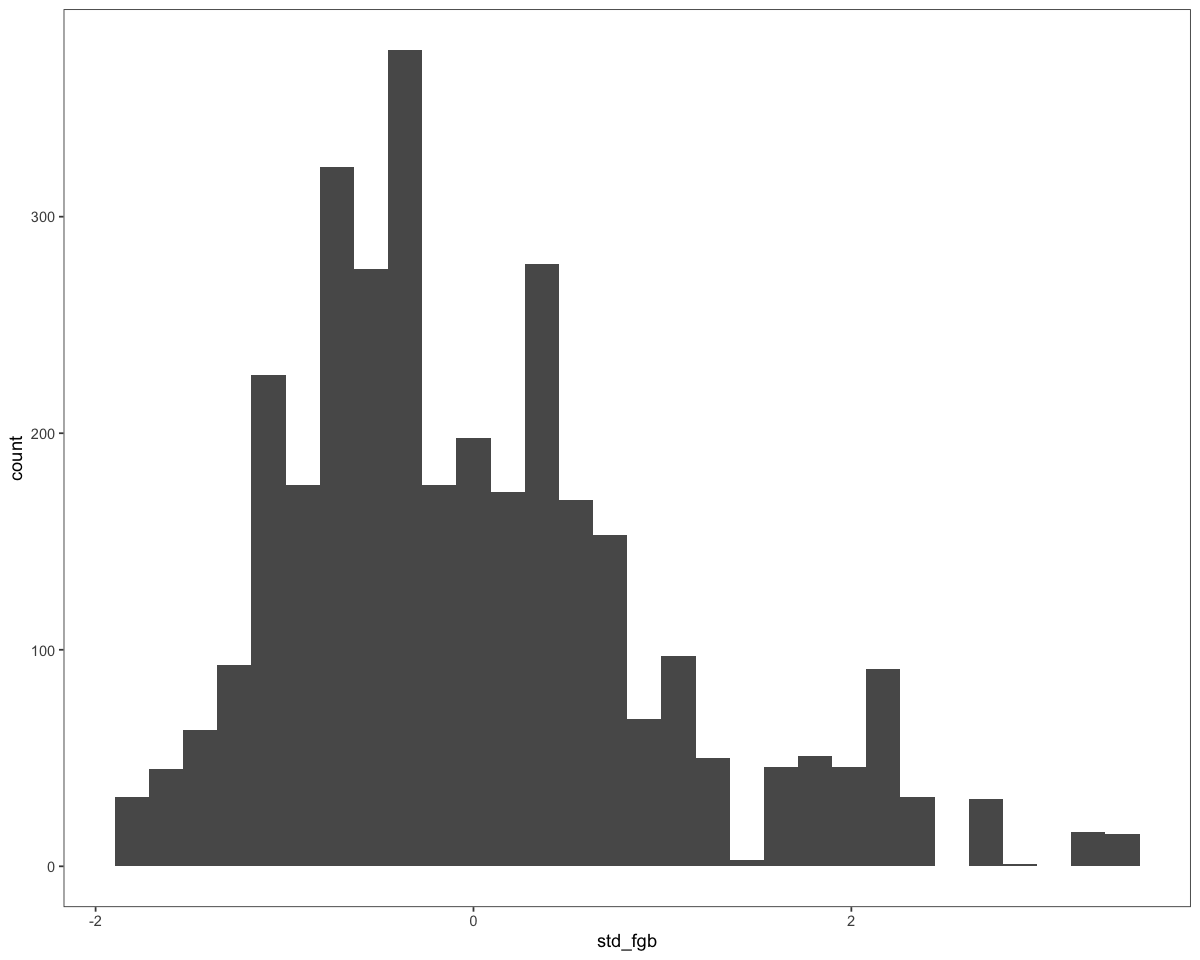

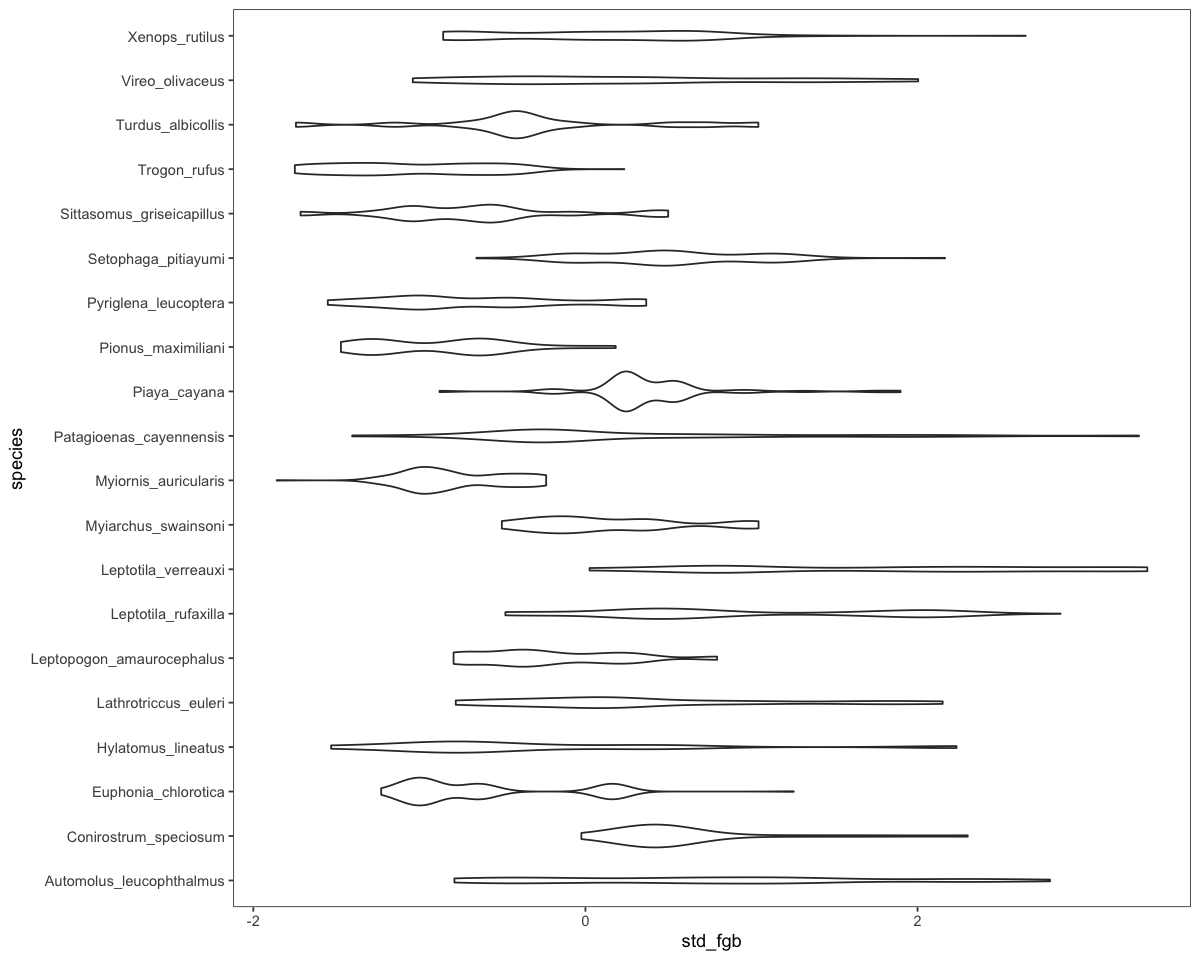

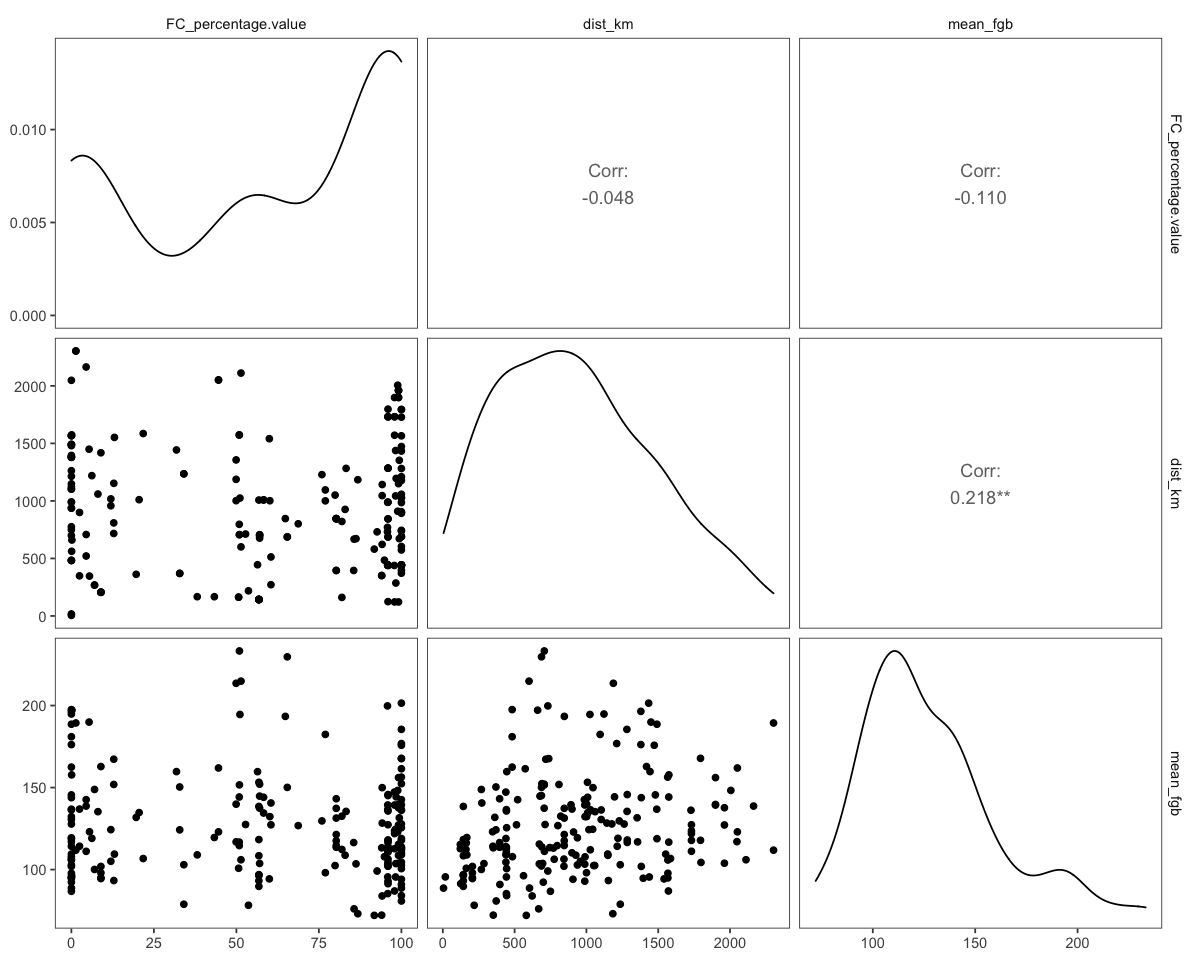

In [16]:
options(repr.plot.width=10, repr.plot.height=8)

FGB_FC_data = FGB_FC_data %>%
                mutate(std_fgb = scale(mean_fgb))%>%
                mutate        
# z standardise mean_fgb for model fitting purposes

plot_hist <- ggplot(FGB_FC_data, aes(x=std_fgb)) + 
              geom_histogram(bins = 30) +
                theme_article()
plot_hist
ggsave("../2.results/plots/FGB_hist.png", plot_hist, width = 7, height=7, units="in")

##
plot_violin <- ggplot(FGB_FC_data, aes(x=std_fgb, y=species)) + 
                geom_violin() +
                theme_article()
plot_violin
ggsave("../2.results/plots/FGB_per_species.png", plot_violin, width = 7, height=8, units="in")

##
plot_pairs <- FGB_FC_data %>%
                filter(FC_buffer == 600) %>%
                ggpairs(data=. ,columns = c('FC_percentage.value', 'dist_km', 'mean_fgb'))+
                theme_article()

plot_pairs
ggsave("../2.results/plots/FGB_FC_600_dist.png", plot_pairs, width = 7, height=7, units="in")
 

## Model Fitting

Fit a model predicting feather growth bars as a function of distance to range edge plus a random effect of species on distance.

In [17]:
FGB_FC_data %>%
        write_csv("../FGB_FC_final.csv")

In [18]:
names(FGB_FC_data)

FGB_FC_data %>%
dplyr::filter(FC_buffer == 600)%>%
nrow()

FGB_FC_data %>%
distinct(species)%>%
nrow()

FGB_FC_data %>%
distinct(location)%>%
nrow()

FGB_FC_data %>%
pull(date_collected)%>%
range()

[1] "species"             "subspecies"          "date_collected"     
 [4] "bird_id"             "lon_dd"              "lat_dd"             
 [7] "location"            "source"              "inrange"            
[10] "distance_sgn"        "dist_km"             "mean_fgb"           
[13] "n_bars"              "decade"              "biome"              
[16] "geometry"            "file_name"           "FC_buffer"          
[19] "FC_percentage.value" "std_fgb"

[1] 213

[1] 20

[1] 151

[1] 1946 2017

### Bayesian models for FGB

Formula used is brm(bf(std_fgb ~ 0, sigma ~ log(dist_km) + (log(dist_km)| species)).
The first term is relative to the mean, that I am not modelling because it doesn't make sense. As there is no directionality in the data, there will are no true differences between left and right, therefore the mean is zero. So I decided to model the variance, which is the second term of the formula (sigma).
The second term models the variance of FA with log of distance to the range edge as a fixed effect and a random effect consistent of a random intercept for distance and random slopes for species.

Using brms default priors  = weakly informative

In [16]:
load("..//2.results/bayesmodels.RData")
ls()

[1] "bay_mod_t"        "bay_mod_w"        "dist"             "FA"              
 [5] "FA_data"          "FA_FC_data"       "FC"               "plot_FA_ind_size"
 [9] "plot_hist"        "plot_pairs"       "plot_violin"

In [70]:
set.seed(1)

bay_mod_fgb <- FGB_FC_data %>%
filter(FC_buffer == 600) %>%
mutate(FC_proportion = FC_percentage.value/100) %>%
brm(bf(std_fgb ~ FC_proportion*log(dist_km) + (log(dist_km) | species), sigma ~ log(dist_km) + (log(dist_km)|species)),
    data = .,
    family = gaussian,
    cores = 4, chains = 1, iter = 10000, 
    control=list(adapt_delta = 0.99))

Compiling Stan program...

Start sampling




SAMPLING FOR MODEL 'fa6a3f42061e2c2af7a1302feaf515fa' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.000333 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 3.33 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 10000 [  0%]  (Warmup)
Chain 1: Iteration: 1000 / 10000 [ 10%]  (Warmup)
Chain 1: Iteration: 2000 / 10000 [ 20%]  (Warmup)
Chain 1: Iteration: 3000 / 10000 [ 30%]  (Warmup)
Chain 1: Iteration: 4000 / 10000 [ 40%]  (Warmup)
Chain 1: Iteration: 5000 / 10000 [ 50%]  (Warmup)
Chain 1: Iteration: 5001 / 10000 [ 50%]  (Sampling)
Chain 1: Iteration: 6000 / 10000 [ 60%]  (Sampling)
Chain 1: Iteration: 7000 / 10000 [ 70%]  (Sampling)
Chain 1: Iteration: 8000 / 10000 [ 80%]  (Sampling)
Chain 1: Iteration: 9000 / 10000 [ 90%]  (Sampling)
Chain 1: Iteration: 10000 / 10000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 238.653 seconds (Warm-up)
Chain 1:                365.139 seconds

Warning message:
“There were 1 divergent transitions after warmup. See
http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup
to find out why this is a problem and how to eliminate them.”
Warning message:
“There were 4999 transitions after warmup that exceeded the maximum treedepth. Increase max_treedepth above 10. See
http://mc-stan.org/misc/warnings.html#maximum-treedepth-exceeded”
Warning message:
“Examine the pairs() plot to diagnose sampling problems
”


In [71]:
summary(bay_mod_fgb)

Warning message:
“There were 1 divergent transitions after warmup. Increasing adapt_delta above 0.99 may help. See http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup”


 Family: gaussian 
  Links: mu = identity; sigma = log 
Formula: std_fgb ~ FC_proportion * log(dist_km) + (log(dist_km) | species) 
         sigma ~ log(dist_km) + (log(dist_km) | species)
   Data: . (Number of observations: 213) 
  Draws: 1 chains, each with iter = 10000; warmup = 5000; thin = 1;
         total post-warmup draws = 5000

Group-Level Effects: 
~species (Number of levels: 20) 
                                      Estimate Est.Error l-95% CI u-95% CI Rhat
sd(Intercept)                             0.68      0.47     0.05     1.79 1.00
sd(logdist_km)                            0.09      0.07     0.00     0.25 1.00
sd(sigma_Intercept)                       0.54      0.49     0.03     1.93 1.00
sd(sigma_logdist_km)                      0.07      0.07     0.00     0.27 1.00
cor(Intercept,logdist_km)                -0.21      0.57    -0.97     0.91 1.00
cor(sigma_Intercept,sigma_logdist_km)    -0.42      0.57    -0.99     0.86 1.00
                                      Bulk_ES

In [73]:
# hypothesis testing for dist to edge smaller than zero
hypothesis(bay_mod_fgb, "logdist_km < 0")
# hypothesis testing for forest cover smaller than zero
hypothesis(bay_mod_fgb, "FC_proportion<0")

Hypothesis Tests for class b:
        Hypothesis Estimate Est.Error CI.Lower CI.Upper Evid.Ratio Post.Prob
1 (logdist_km) < 0     0.12       0.1    -0.06     0.27       0.11       0.1
  Star
1     
---
'CI': 90%-CI for one-sided and 95%-CI for two-sided hypotheses.
'*': For one-sided hypotheses, the posterior probability exceeds 95%;
for two-sided hypotheses, the value tested against lies outside the 95%-CI.
Posterior probabilities of point hypotheses assume equal prior probabilities.

Hypothesis Tests for class b:
           Hypothesis Estimate Est.Error CI.Lower CI.Upper Evid.Ratio Post.Prob
1 (FC_proportion) < 0     1.73      1.08    -0.18     3.39       0.07      0.07
  Star
1     
---
'CI': 90%-CI for one-sided and 95%-CI for two-sided hypotheses.
'*': For one-sided hypotheses, the posterior probability exceeds 95%;
for two-sided hypotheses, the value tested against lies outside the 95%-CI.
Posterior probabilities of point hypotheses assume equal prior probabilities.

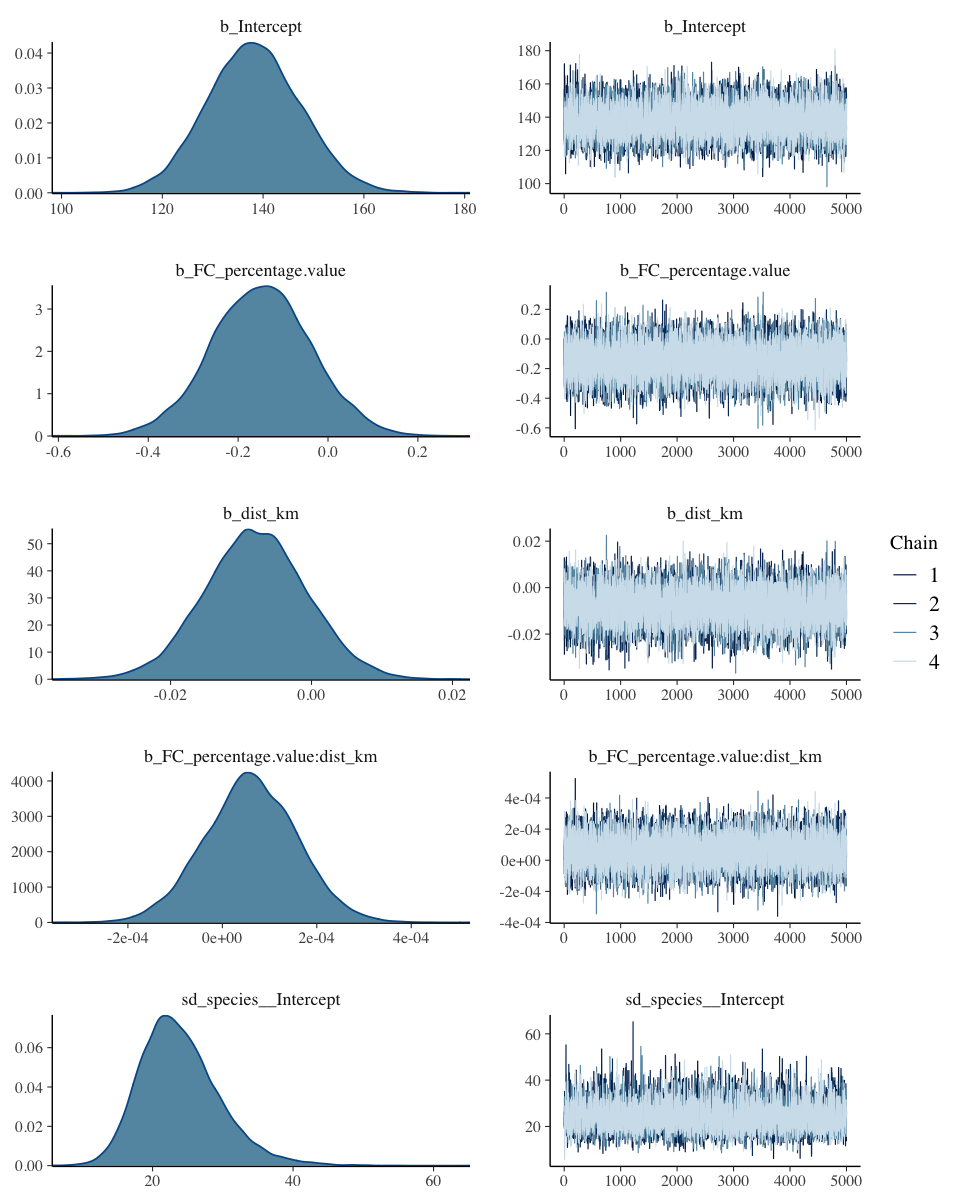

pdf 
  2

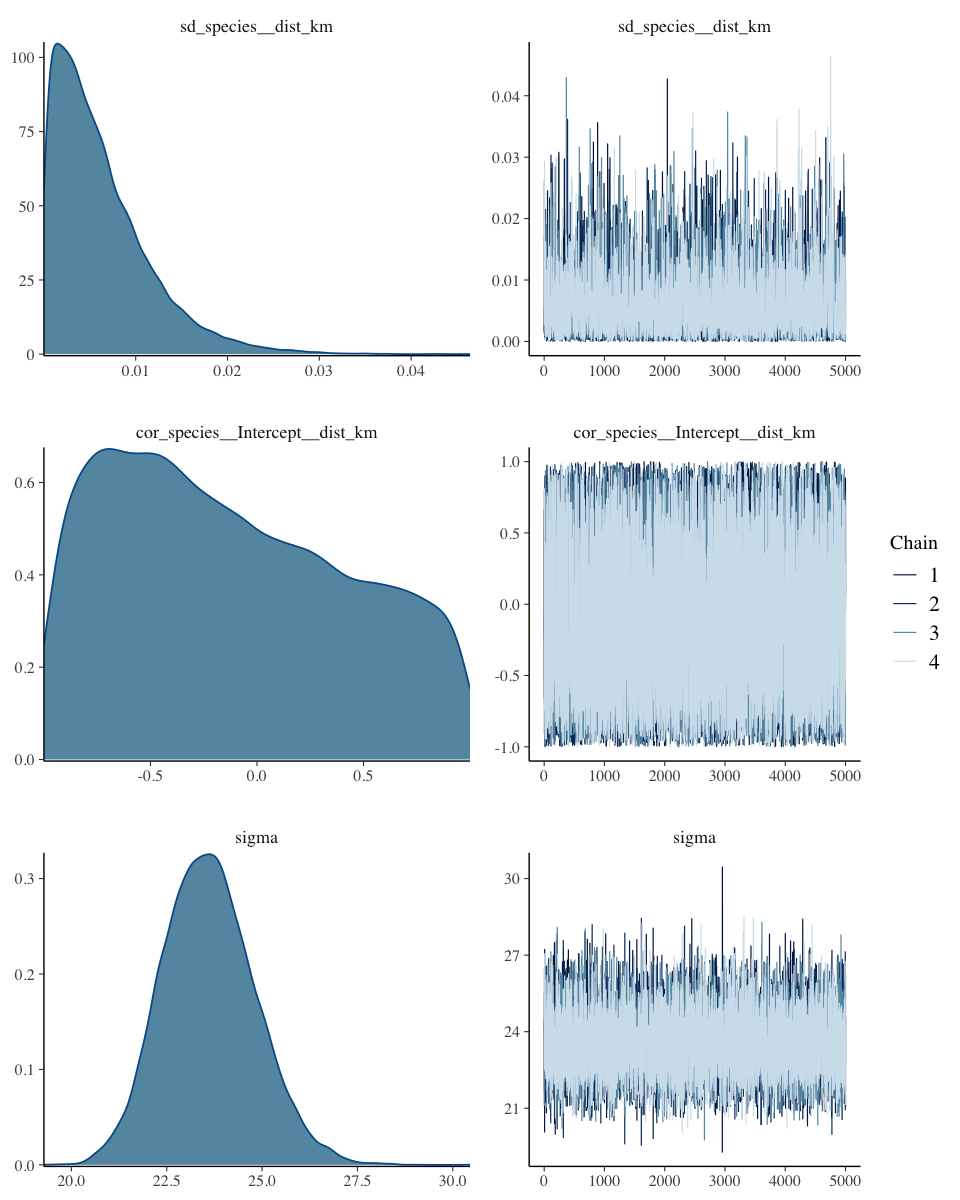

In [67]:
options(repr.plot.width=8, repr.plot.height=10)
plot(bay_mod_fgb)

png(file="../2.results/plots/bayes_fgb_coefs_chains.png", width=7, height = 10, units="in", res = 1200)
plot(bay_mod_fgb)
dev.off()


pdf 
  2

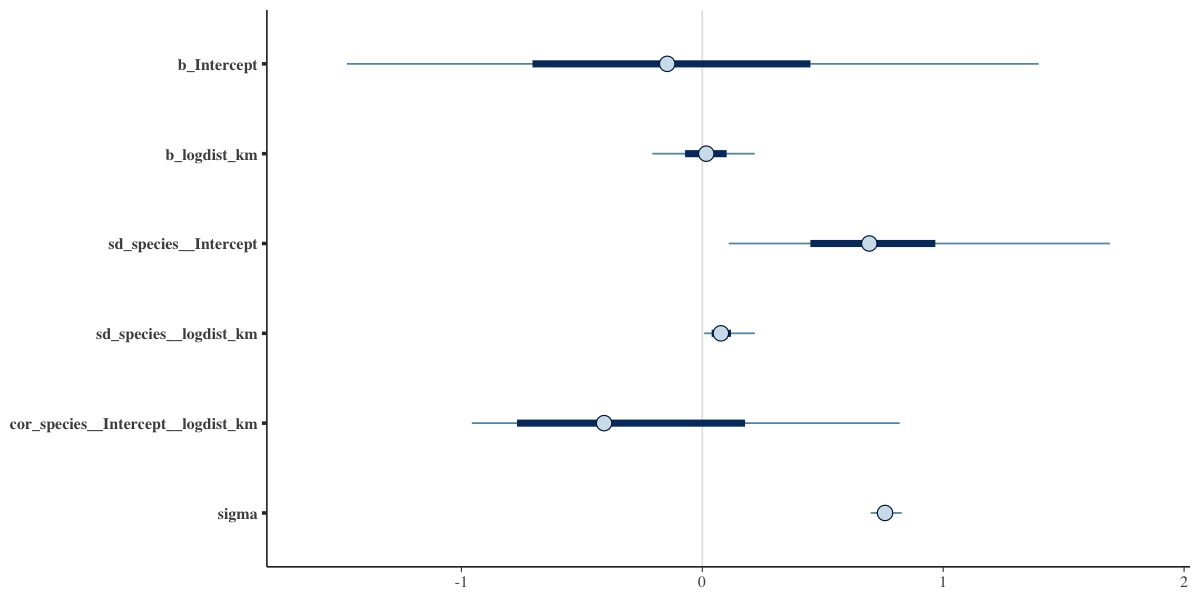

In [57]:
options(repr.plot.width=10, repr.plot.height=5)
mcmc_plot(bay_mod_fgb)

png(file="../2.results/plots/bayes_fgb_coef.png", width=7, height = 10, units="in", res = 1200)
mcmc_plot(bay_mod_fgb)
dev.off()


pdf 
  2

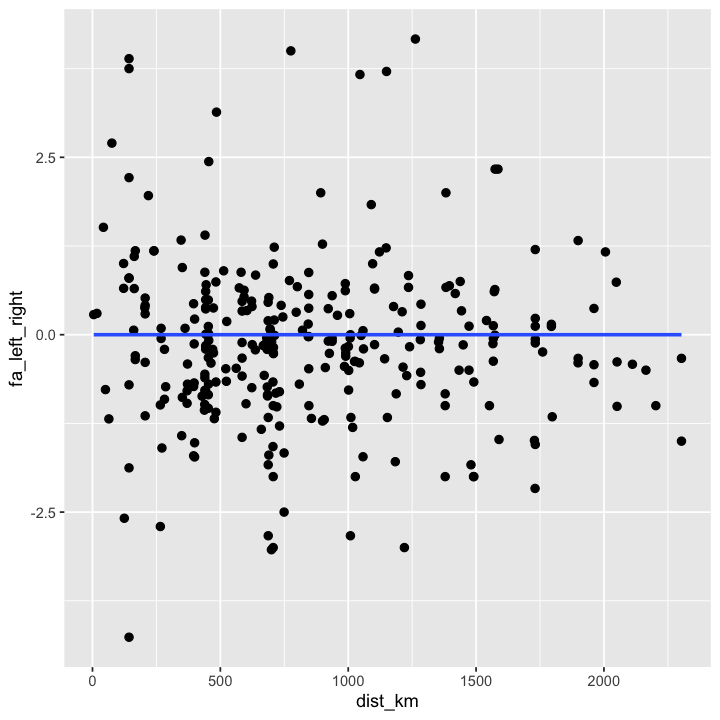

In [47]:
options(repr.plot.width=6, repr.plot.height=6)

plot(conditional_effects(bay_mod_fgb), points = TRUE)

png(file="../2.results/plots/bayes_fgb_cond_effects.png", width=7, height = 10, units="in", res = 1200)
plot(conditional_effects(bay_mod_fgb), points = TRUE)
dev.off()


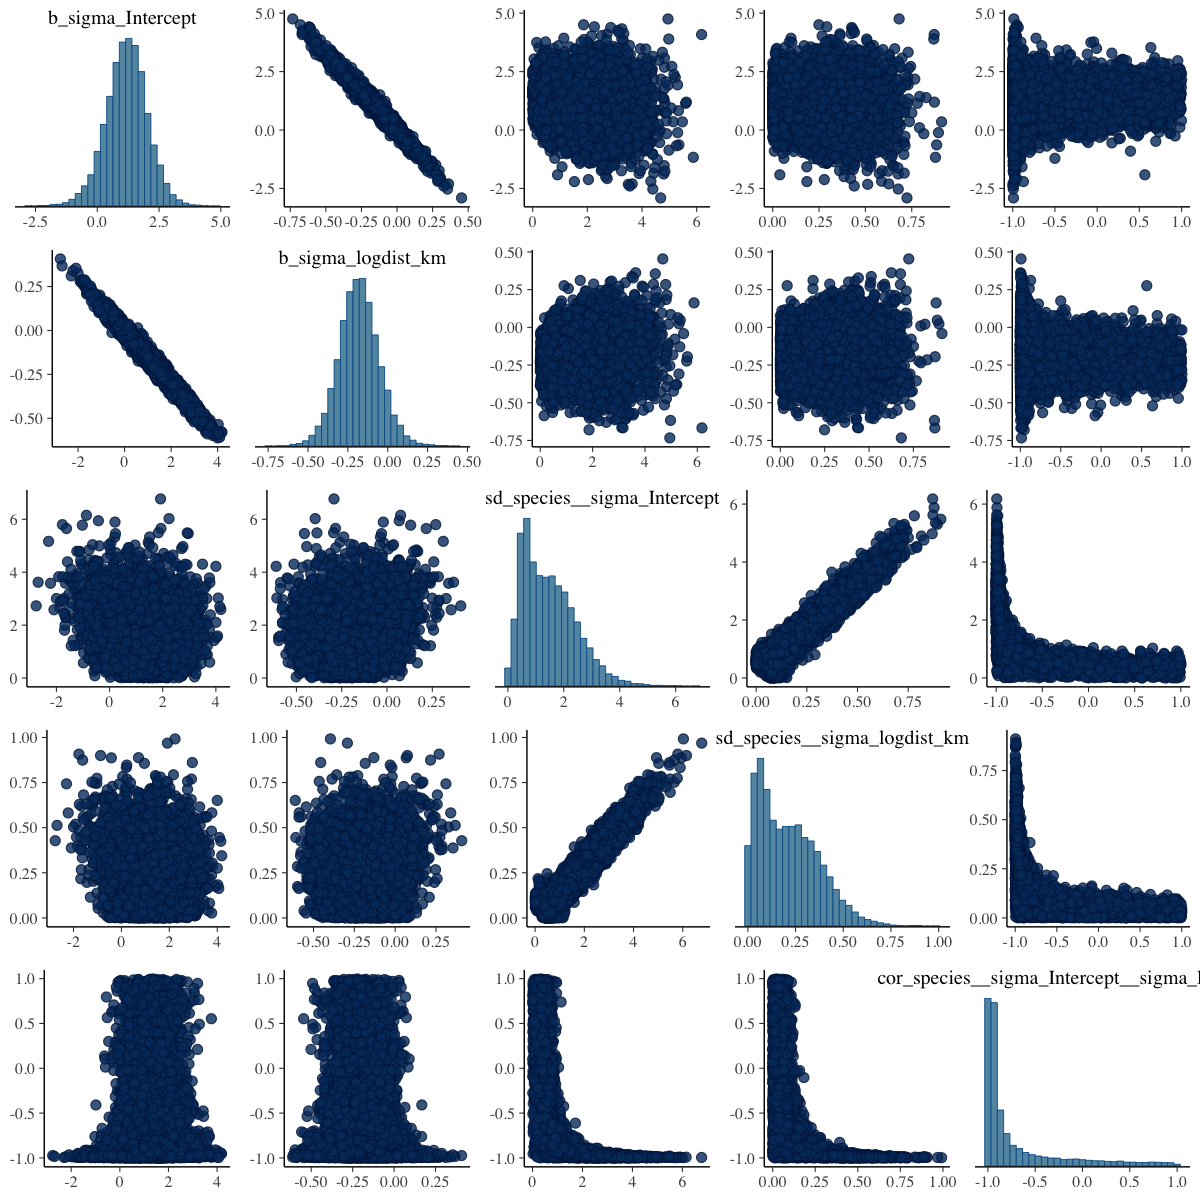

In [37]:
options(repr.plot.width=10, repr.plot.height=10)
pairs(bay_mod_fgb)